[Collaboration &lt;](Collaboration.ipynb) | [&gt; ML Frameworks](Frameworks.ipynb)

# Other Python Packages 
What other Python packages are people using and how is that usage related to the ML framework choice. For this analysis we only look at notebooks written in Python. 

## Results Summary:
- Numpy, pandas, and matplotlib are the three most common imports.
- Frequently co-occuring (correlation > 0.3): 
    - numpy and matplotlib, r = 0.56
    - numpy and pandas, r = 0.31
    - numpy and sklearn, r = 0.32
    - matplotlib and seaborn, r = 0.34
    - pandas and sklearn, r = 0.36
    - pandas and seaborn, r = 0.37
    - sklearn and os, r = 0.35
    - sklearn and re, r = 0.51
    - os and re, r = 0.34
    - time and datetime, r = 0.61


- a -> b means that if a is imported into a notebook, b has at least a 90% chance of also being imported into that notebook. Further, the probability that both a and b are imported into a notebook is at least 10%. A lot of imports (and sets of imports) have strong implications that numpy will also be imported. This indicates that a lot of packages depend on numpy. Further, it seems that seaborn depends on seaborn, but the reverse is not true. A list of association rules is at the bottom of this notebook

- The use of numpy does not seem to have been affected by their plan to get rid of Python 2 support.

----------

# Import Packages & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
import pickle
import datetime
from apyori import apriori
import re


import load_data

Load dataframe

In [2]:
notebooks_temp = load_data.load_notebooks()
repos_temp = load_data.load_repos()

Notebooks loaded in 0:00:35.461090
Repos loaded in 0:00:05.758682


Load aggregated dataframe. Code used to create it is in [aggregate.py](aggregate.py).

In [3]:
nb_imports_df_temp = load_data.load_nb_imports()

Notebook imports loaded in 0:00:45.175603


---------
# Tidy Data

### Only looking at Python notebooks

In [4]:
notebooks = notebooks_temp.copy()[notebooks_temp.lang_name == 'python'].reset_index(drop=True)

# another one with julia and R too, to compare to Adam's research
notebooks_py_ju_r = notebooks_temp.copy()[notebooks_temp.lang_name.isin(['python','r','julia'])].reset_index(drop=True)

In [5]:
print("{0} ({1}%) of notebooks were written in Python. The remaining {2}% have been removed.".format(
    len(notebooks),
    round(100*len(notebooks)/len(notebooks_temp), 2),
    round(100 - 100*len(notebooks)/len(notebooks_temp), 2)
))

4115126 (95.91%) of notebooks were written in Python. The remaining 4.09% have been removed.


### Update aggregated dataframe to reflect notebooks in question

In [6]:
nb_imports_df = nb_imports_df_temp.copy()[nb_imports_df_temp.file.isin(notebooks.file)].reset_index(drop=True)
repos = repos_temp.copy()[repos_temp.repo_id.isin(notebooks.repo_id)].reset_index(drop=True)

# another one with julia and R too, to compare to Adam's research
nb_imports_py_ju_r = nb_imports_df_temp.copy()[nb_imports_df_temp.file.isin(notebooks_py_ju_r.file)].reset_index(drop=True)

### Delete temp dataframes to save space

In [7]:
del notebooks_temp
del repos_temp
del nb_imports_df_temp

---
# Manipulate Data

### List of all imports

In [8]:
# 20 seconds
start = datetime.datetime.now()
all_imports = []
for im in nb_imports_df.imports:
    all_imports += set([i[0].split('.')[0] for i in im])
end = datetime.datetime.now()
print(end - start)

0:00:18.607818


---
# Visualizations & Statistics

In [9]:
print("{0}% of notebooks written in jula, python, or R have imports.".format(
    round(100*sum([i != [] for i in nb_imports_py_ju_r.imports])/len(nb_imports_py_ju_r),2)
))

print("{0}% of notebooks written in python have imports.".format(
    round(100*sum([i != [] for i in nb_imports_df.imports])/len(nb_imports_df),2)
))

86.94% of notebooks written in jula, python, or R have imports.
88.42% of notebooks written in python have imports.


## Python Package Imports

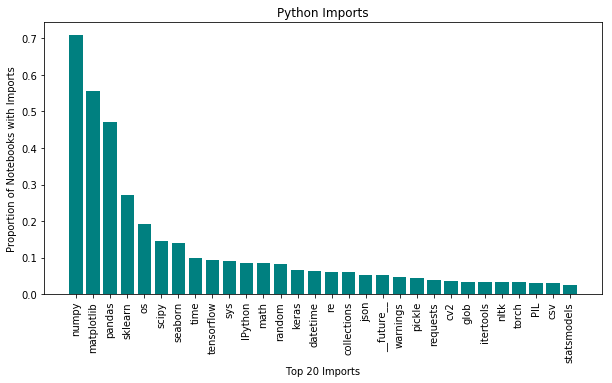

0:00:08.511427


In [10]:
# 12 seconds
start = datetime.datetime.now()

top_n_with = pd.Series(all_imports).value_counts()[0:30]/sum(
    [n!=[] for n in nb_imports_df.imports]
)
top_n_all = pd.Series(all_imports).value_counts()[0:30]/len(nb_imports_df)
top_packages = top_n_with.index
pos = np.arange(len(top_packages))
height = top_n_with.values
fig = plt.figure(figsize=(10,5))
plt.bar(pos, height, color = 'teal')
plt.xticks(pos, top_packages, rotation = 90)
plt.title('Python Imports')
plt.xlabel('Top 20 Imports')
plt.ylabel('Proportion of Notebooks with Imports')
plt.show()

end = datetime.datetime.now()
print(end - start)

Numpy, pandas, and matplotlib are the three most common imports. Among notebooks with at least one import, Numpy is used in 70.8%, Matplotlib in 55.6%, and Pandas in 47.1%.

In [11]:
print("Notebooks with at least one import:")
print(top_n_with[:3])
print("\nAll notebooks:")
print(top_n_all[:3])

Notebooks with at least one import:
numpy         0.708448
matplotlib    0.556438
pandas        0.470889
dtype: float64

All notebooks:
numpy         0.626435
matplotlib    0.492022
pandas        0.416377
dtype: float64


## What packages are frequently used together in a notebooks?

### Test for independence of all packages
Ho: $\Sigma = \Sigma_0 =$ diagonal matrix of variances. All packages are imported independently.

Ha: $\Sigma \ne \Sigma_0$ Not all packages are imported independently.

U = det(sample covariance matrix) / product(sample variances)

Under the null hypothesis, we expect U = 1

In [12]:
# 3 minutes
start = datetime.datetime.now()
for package in top_packages:
    if package not in nb_imports_df.columns:
        nb_imports_df[package] = [
            package in ' '.join([i[0] for i in im])
            for im in nb_imports_df.imports
        ]
        print(package, datetime.datetime.now() - start)
end = datetime.datetime.now()
print(end - start)

numpy 0:00:06.439607
matplotlib 0:00:13.003406
pandas 0:00:19.528927
sklearn 0:00:26.114389
os 0:00:32.768888
scipy 0:00:39.345341
seaborn 0:00:46.036742
time 0:00:52.745045
tensorflow 0:00:59.358515
sys 0:01:05.928028
IPython 0:01:12.418003
math 0:01:18.893558
random 0:01:25.603042
keras 0:01:32.184978
datetime 0:01:38.886658
re 0:01:45.284120
collections 0:01:51.966712
json 0:01:58.654581
__future__ 0:02:05.044091
warnings 0:02:11.800722
pickle 0:02:18.462206
requests 0:02:25.057956
cv2 0:02:31.592250
glob 0:02:38.046751
itertools 0:02:44.731427
nltk 0:02:51.296931
torch 0:02:57.846025
PIL 0:03:04.225053
csv 0:03:10.810354
statsmodels 0:03:17.492344
0:03:17.492896


In [13]:
cov = nb_imports_df[top_packages].cov()
U = np.linalg.det(cov) / np.diag(cov).prod()
U

0.03159127292287232

U = 0.03 is very far from 1, providing very strong evidence that not all packages are imported independent.

### Not all packages are imported independently, so which are associated?

#### Looking at correlations

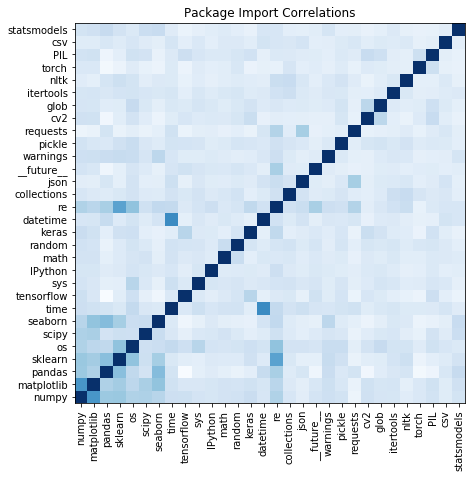

In [14]:
df = nb_imports_df[top_packages].corr().transpose()
fig = plt.figure(figsize = (7,7))
plt.pcolor(df, cmap = 'Blues')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation = 90)
plt.title("Package Import Correlations")
plt.show()

#### Colors can be tricky to distinguish, objectively focus on correlations over 0.3.

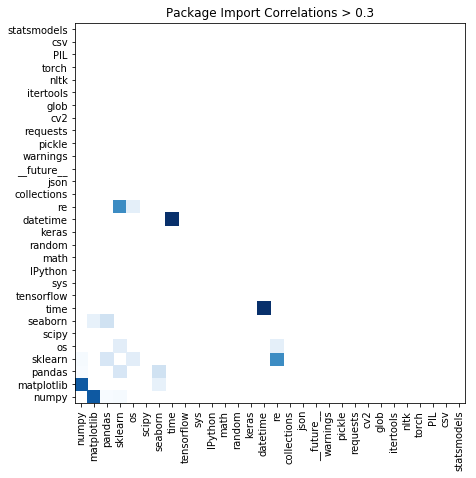

In [15]:
df_over_03 = df[np.logical_and(df > 0.3, df < 1)]
fig = plt.figure(figsize = (7,7))
plt.pcolor(df_over_03, cmap = 'Blues')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation = 90)
plt.title("Package Import Correlations > 0.3")
plt.show()

In [16]:
print('Frequently co-occuring (correlation > 0.3):\n')
c_num = 0
for c in df_over_03.columns:
    for i in df_over_03.index[c_num:]:
        corr = df_over_03.loc[i, c]
        if corr > 0.3:
            print('{0} and {1}, r = {2}'.format(c, i, round(corr, 2)))
    c_num += 1

Frequently co-occuring (correlation > 0.3):

numpy and matplotlib, r = 0.56
numpy and pandas, r = 0.31
numpy and sklearn, r = 0.32
matplotlib and seaborn, r = 0.34
pandas and sklearn, r = 0.36
pandas and seaborn, r = 0.37
sklearn and os, r = 0.35
sklearn and re, r = 0.51
os and re, r = 0.34
time and datetime, r = 0.61


#### Looking at frequent item sets

Support = frequency of items. Minimum support = 10%, items have to occur together in at least 10% of notebooks.

Confidence = conditional probability. Minimum confidence = 90%, a -> b if pr(b|a) is at least 0.9.

In [17]:
f = open('analysis_data/packages_records.list', 'rb')
records = pickle.load(f)
f.close()

In [18]:
start = datetime.datetime.now()

association_rules = apriori(records, min_support=0.10, min_confidence=0.90, min_lift=0, min_length=2)  
association_results = list(association_rules) 

end = datetime.datetime.now()
print(end - start)


0:00:31.334428


#### Association Rules

a -> b means that if a is imported into a notebook, b has at least a 90% chance of also being imported into that notebook. Further, the probability that both a and b are imported into a notebook is at least 10%.


In [19]:
for item in association_results:
    # first index of the inner list
    # Contains base item and add i+tem
    first = item.ordered_statistics[0].items_base
    second = item.ordered_statistics[0].items_add
    print(', '.join([x for x in first]), '->', ', '.join([x for x in second]))

#     print("Support: " + str(item[1]))

#     #third index of the list located at 0th
#     #of the third index of the inner list

#     print("Confidence: " + str(item[2][0][2]))
#     #print("Lift: " + str(item[2][0][3]))
#     print("=====================================")

matplotlib -> numpy
seaborn -> matplotlib
scipy -> numpy
seaborn -> numpy
seaborn -> pandas
os, matplotlib -> numpy
pandas, matplotlib -> numpy
re, matplotlib -> numpy
scipy, matplotlib -> numpy
seaborn, matplotlib -> numpy
sklearn, matplotlib -> numpy
seaborn, matplotlib -> pandas
sklearn, os -> numpy
numpy, seaborn -> pandas
pandas, sklearn -> numpy
sklearn, re -> numpy
pandas, os, matplotlib -> numpy
re, os, matplotlib -> numpy
pandas, re, matplotlib -> numpy
pandas, sklearn, matplotlib -> numpy
re, sklearn, matplotlib -> numpy
pandas, os, re -> numpy
sklearn, os, re -> numpy
pandas, sklearn, re -> numpy
pandas, re, sklearn, matplotlib -> numpy


In [20]:
pr_sea = sum(['seaborn' in im for im in records]) / len(records)
pr_mat = sum(['matplotlib' in im for im in records]) / len(records)
pr_sea_mat = sum(['seaborn' in im and 'matplotlib' in im for im in records]) / len(records)
print('Pr(Matplotlib) =', round(pr_mat, 2))
print('Pr(Seaborn) =', round(pr_sea, 2))
print('Pr(Matplotlib | Seaborn) =', round(pr_sea_mat/pr_sea,2))
print('Pr(Seaborn | Matplotlib) =', round(pr_sea_mat/pr_mat, 2))


Pr(Matplotlib) = 0.49
Pr(Seaborn) = 0.12
Pr(Matplotlib | Seaborn) = 0.94
Pr(Seaborn | Matplotlib) = 0.24


## Use of Numpy

In [21]:
code_df_temp = load_data.load_code()
code_df_numpy = code_df_temp[code_df_temp.file.isin(nb_imports_df[nb_imports_df['numpy']].file)]
code_df_numpy = code_df_numpy.merge(nb_imports_df[['imports','file']], on = 'file')

del code_df_temp


Code loaded in 0:03:16.493127


In [22]:
# 12 minutes
code_updated = []
numpy_uses = []
start = datetime.datetime.now()
for i, row in code_df_numpy.iterrows():
    f = row.file
    imports = row.imports
    try:
        numpy_im = [i for i in imports if i[0].startswith('numpy')][0]
    except:
        pass
    row_updated = [c.replace(numpy_im[1], numpy_im[0]) for c in row.code if type(c) == str]
    code_updated.append(row_updated)
    numpy_uses.append(load_data.flatten([re.findall('numpy\.[a-zA-Z_\.]+', c) for c in row_updated]))
    if i%500000 == 0:
        print(i, datetime.datetime.now() - start)
end = datetime.datetime.now()
print(end - start)


0 0:00:01.238231
500000 0:02:12.254387
1000000 0:04:23.038928
1500000 0:06:32.421511
2000000 0:08:41.094508
2500000 0:10:50.159123
0:11:10.637160


### How many notebooks import numpy without using it

In [23]:
print("{0}% of notebooks that import numpy never use it.".format(
    round(100*sum([len(n)==0 for n in numpy_uses])/len(numpy_uses), 2)
))
print("{0}% of notebooks that import numpy use it at least 5 times.".format(
    round(100*sum([len(n)>5 for n in numpy_uses])/len(numpy_uses), 2)
))

18.23% of notebooks that import numpy never use it.
45.25% of notebooks that import numpy use it at least 5 times.


### What are the top uses of numpy

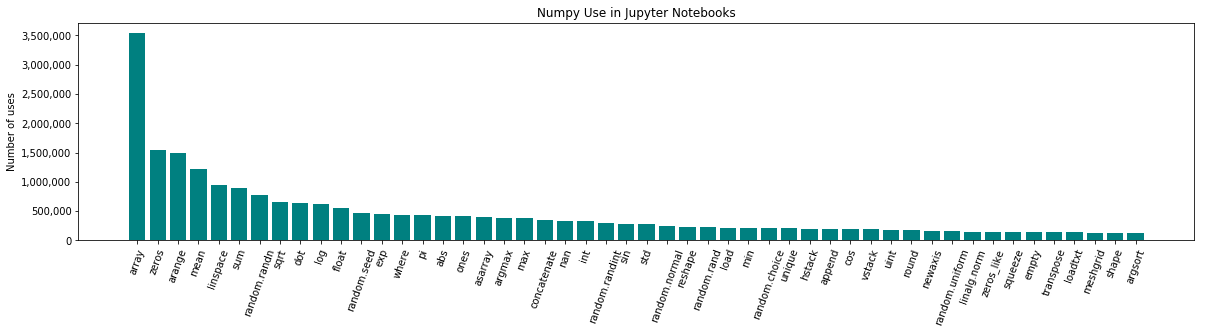

In [24]:
numpy_uses_counts = pd.Series(load_data.flatten(numpy_uses)).value_counts().reset_index().rename(
    columns = {'index':'use',0:'count'}
)

fig = plt.figure(figsize = (20, 4))
x = numpy_uses_counts['use'][:50]
x_pos = np.arange(len(x))
y = numpy_uses_counts['count'][:50]
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, ['.'.join(l.split('.')[1:]) for l in x], rotation = 70)
plt.ylabel('Number of uses')
plt.yticks(
    list(range(0, 4000000, 500000)), 
    ['{:,}'.format(i) for i in range(0, 4000000, 500000)]
)
plt.title('Numpy Use in Jupyter Notebooks')
plt.show()

#### Numpy is planning to get rid of support for Python2. Did this announcement (2018) change it's use patterns?

In [25]:
repos['pushed_at'] = pd.to_datetime(repos['pushed_at'])
repos['month'] = [p.month for p in repos['pushed_at']]
repos['year'] = [p.year for p in repos['pushed_at']]
nb_imports_time_df = nb_imports_df.merge(notebooks[['file','repo_id']], on = 'file').merge(repos, on = ['repo_id'])

In [26]:
def get_numpy_over_time(df, title):
    numpy_time_df = df.groupby(['year','month'])['numpy'].sum().reset_index().sort_values(by = ['year','month']).reset_index(drop=True).merge(
        df.groupby(['year','month'])['file'].count().reset_index(),
        on = ['year','month']
    )
    numpy_time_df['prop'] = numpy_time_df['numpy'] / numpy_time_df['file']
    numpy_time_df['order'] = list(range(len(numpy_time_df)))
    numpy_time_df['label'] = ['January '+str(int(r.year)) if r.month == 1 else '' for _, r in numpy_time_df.iterrows()]
    
    plt.plot(numpy_time_df.order, numpy_time_df.prop, color = 'teal')
    plt.xticks(numpy_time_df.order, numpy_time_df.label, rotation = 70)
    plt.title('Use of Numpy over time in {0} Notebooks'.format(title))
    plt.ylabel('Proportion of Notebooks')
    plt.show()

In [27]:
get_numpy_over_time(nb_imports_time_df, 'Python')


nb_imports_py2_time_df = nb_imports_df.merge(
    notebooks[[str(l).startswith('2') for l in notebooks.lang_version]&(notebooks.lang_name == 'python')][['file','repo_id']], on = 'file'
).merge(repos, on = ['repo_id'])

get_numpy_over_time(nb_imports_py2_time_df, 'Python 2')

nb_imports_py3_time_df = nb_imports_df.merge(
    notebooks[[str(l).startswith('3') for l in notebooks.lang_version]&(notebooks.lang_name == 'python')][['file','repo_id']], on = 'file'
).merge(repos, on = ['repo_id'])

get_numpy_over_time(nb_imports_py3_time_df, 'Python 3')

MemoryError: 

[Collaboration &lt;](Collaboration.ipynb) | [&gt; ML Frameworks](Frameworks.ipynb)